#### Loading Packages

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Read in & Clean Data
- will need to remove cabin and age columns
- some cells in embarked are null so won't need to remove all but can just remove those rows

In [26]:
original_data = pd.read_csv("./titanic-data/train.csv")
print(f"Training data original shape: {original_data.shape}")

# Removing columns and rows will null data cells
training_data = original_data.drop(columns = 'Cabin') # removed whole column since majority were NA
training_data = training_data.dropna() # cleans out NA values spread out between columns by removing whole entire row

# print(f"Cabin Column Dropped due to many null values:\n{training_data}")
print(f"Training data shape after cleaning: {training_data.shape}")
print(f"Samples Removed: {original_data.shape[0] - training_data.shape[0]}")

Training data original shape: (891, 12)
Training data shape after cleaning: (712, 11)
Samples Removed: 179


#### One Hot Encoding
- go back and implement own one hot encoding function

In [27]:
X = training_data.drop('Survived', axis = 1)
# removes columns that have no effect on an outcome and help reduce dimensionality before training
X = X.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
print(f"Training data before one-hot encoding:\n\n{X.head()}")
y = training_data['Survived']

X = pd.get_dummies(X, columns=['Sex', 'Embarked'], dtype=int, drop_first = True)

# Sex_female and Embarked_C not included due to drop_first being set to True
print("\n\n")
print(f"Training data after one-hot encoding:\n\n{X.head()}")

Training data before one-hot encoding:

   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S
3       1  female  35.0      1      0  53.1000        S
4       3    male  35.0      0      0   8.0500        S



Training data after one-hot encoding:

   Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S
0       3  22.0      1      0   7.2500         1           0           1
1       1  38.0      1      0  71.2833         0           0           0
2       3  26.0      0      0   7.9250         0           0           1
3       1  35.0      1      0  53.1000         0           0           1
4       3  35.0      0      0   8.0500         1           0           1


#### Functions for Logistic Regression

In [40]:
def sigmoid(z):
  #   returns sigmoid = 1/(1 + e^-z)
  #   -> handles vectors/matrices
  sigmoid = 1 / (1 + np.exp(-z))
  return sigmoid


def initialize_params(m_features, seed=None):
  #   returns vector (w) of size (m x 1) features with small random numbers, and the scalar b initialized to 0
  #   -> b = 0
  #   call this from one-hot encoding or create another section after one-hot encoding to do this
  #   - plug our samples into this function to get y_hat values
  # (0, 0.01) represents a gaussian distribution with mean 0 and std 0.01
  # -> might need to be adjusted late for model accuracy
  w = np.random.default_rng(seed).normal(0, 0.01, size=(m_features, 1))
  b = 0
  return w, b


def forward(X, w, b):
  #   returns
  #     z = X * w + b
  #     y_hat (pred) = sigmoid(z)
  X = X.to_numpy()
  z = np.dot(X, w) + b
  y_hat = sigmoid(z)
  return y_hat, z


def compute_cost(y, y_hat, eps=1e-12):
  #   -> computes binary cross-entropy cost w/ optional L2 penalty
  #   - check with notes:
  #     -> cost = -1/n * sum(y_i * log(y_hat_i) + (1 - y_i) * log(1 - y_hat_i))
  #     -> cost += reg_lambda / 2 * sum(w^2)
  n = X.shape[0]
  y = y.to_numpy()
  y = y.reshape(n, 1)
  y_hat = np.clip(y_hat, eps, 1 - eps)
  cost = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
  return cost


def compute_gradients(X, y, y_hat, w, reg_lambda=0.0):
  #   - dw = (1/n) * X * (y_hat - y) + (reg_lambda / n) * w
  #   - db = (1/n) * sum(y_hat_i - y_i) -> find the mean difference between y_hat (pred) and y (target)
  X = X.to_numpy()
  n = X.shape[0]  # represents num of features
  y = y.to_numpy()
  y = y.reshape(n, 1)
  pred_difference = y_hat - y
  dw = (1 / n) * np.dot(X.T, pred_difference) + (reg_lambda / n) * w
  db = (1 / n) * (y_hat - y).sum()  # .sum() allows us to take a sum of differences between prediction and target
  return dw, db


def update_params(w, b, dw, db, lr):
  #   Gradient step -> w: = w - (lr * dw)
  #                 -> b: = b - (lr * db)
  w = w - (lr * dw)
  b = b - (lr * db)
  return w, b


def train(X, y, lr, n_epochs, reg_lambda=0.0, X_val=None, y_val=None):
  #   I. training loop
  #       1.) forward pass
  #       2.) compute cost
  #       3.) compute gradients
  #       4.) update parameters
  #            -> track expected loss for each iteration. if X_val and y_val are provided, it will also track validation loss
  features = X.shape[1]
  w, b = initialize_params(features, seed=None)
  cost_history = []

  for epoch in range(n_epochs):
    y_hat, z = forward(X, w, b)
    cost = compute_cost(y, y_hat)
    cost_history.append(cost)
    dw, db = compute_gradients(X, y, y_hat, w, reg_lambda)
    w, b = update_params(w, b, dw, db, lr)

  #   II. Returns the trained parameters 'w' and 'b' and history of the cost for training and validation sets
  return w, b, cost_history


def predict_proba(X, w, b):
  X = X.to_numpy()
  y_hat = np.dot(X.T, w) + b
  return y_hat

#### Training Model with Self-Made Functions

In [44]:
learning_rate = 0.01
n_epochs = 1000
valid_params, bias, cost_history = train(X, y, learning_rate, n_epochs, reg_lambda=0.0, X_val=None, y_val=None)
print(type(cost_history))

<class 'list'>


#### Plotting Cost History

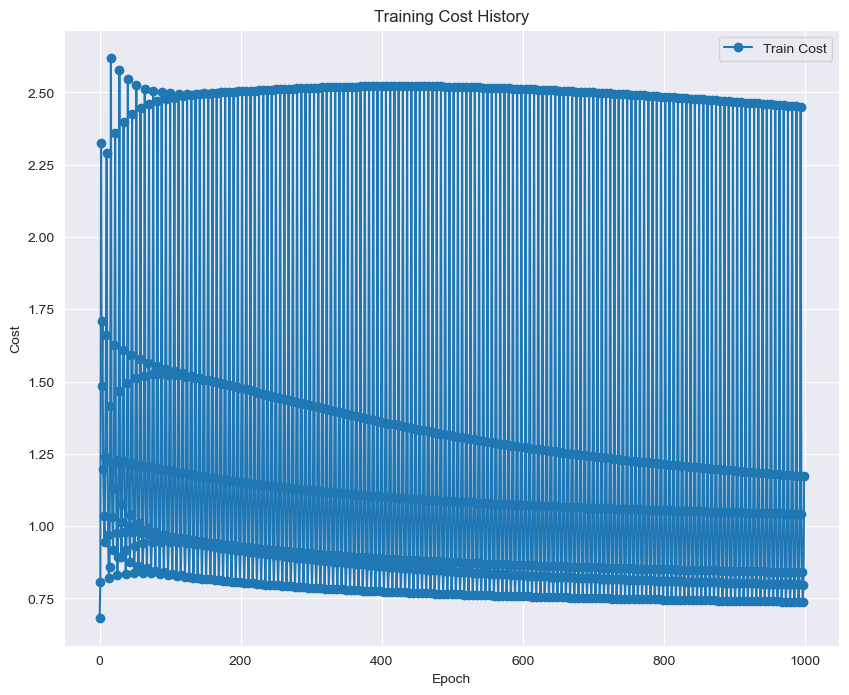

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(range(n_epochs), cost_history, marker='o', linewidth=1.5, label='Train Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training Cost History')
plt.legend()
plt.show()